In [57]:
from NID.datasets import Pinky40
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 128    # training batch size 
    num_of_layers: int = 17 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'S' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.1 # nosie level used on validation set 

# prepare data

In [11]:
dataset_train = Pinky40(train=True)
dataset_val = Pinky40(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, 
                         batch_size=256, shuffle=True)
print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))

# of training samples: 208512

# of testing samples: 325



# configure training options

In [3]:
opt = training_configurations(num_of_layers=10)

# build model 

In [8]:
net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
net.apply(weights_init_kaiming)
criterion = nn.MSELoss(reduction='sum')
# Move to GPU
device_ids = [0]
model = nn.DataParallel(net, device_ids=device_ids).cuda()
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0

# start training

In [19]:
for epoch in range(opt.epochs):
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.
        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('learning rate %f' % current_lr)
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            if opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            out_train = model(imgn_train)
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            loss.backward()
            optimizer.step()
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            if step % 10 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
        ## the end of each epoch
        model.eval()
        # validate
        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)
        # log the images
        out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
        Img = utils.make_grid(img_train.data, nrow=8, normalize=True, scale_each=True)
        Imgn = utils.make_grid(imgn_train.data, nrow=8, normalize=True, scale_each=True)
        Irecon = utils.make_grid(out_train.data, nrow=8, normalize=True, scale_each=True)
        writer.add_image('clean image', Img, epoch)
        writer.add_image('noisy image', Imgn, epoch)
        writer.add_image('reconstructed image', Irecon, epoch)
        # save model
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}.pth'.format(opt.num_of_layers)))


learning rate 0.001000
[epoch 1][1/815] loss: 0.1798 PSNR_train: 37.8843
[epoch 1][2/815] loss: 0.1864 PSNR_train: 37.7036
[epoch 1][3/815] loss: 0.1958 PSNR_train: 37.4847
[epoch 1][4/815] loss: 0.1815 PSNR_train: 37.2220
[epoch 1][5/815] loss: 0.1829 PSNR_train: 37.1536
[epoch 1][6/815] loss: 0.1907 PSNR_train: 37.4637
[epoch 1][7/815] loss: 0.1949 PSNR_train: 37.6909
[epoch 1][8/815] loss: 0.1732 PSNR_train: 37.7698
[epoch 1][9/815] loss: 0.1753 PSNR_train: 37.5691
[epoch 1][10/815] loss: 0.1657 PSNR_train: 37.4563
[epoch 1][11/815] loss: 0.1928 PSNR_train: 37.6999
[epoch 1][12/815] loss: 0.1711 PSNR_train: 38.0420
[epoch 1][13/815] loss: 0.1664 PSNR_train: 37.9590
[epoch 1][14/815] loss: 0.1739 PSNR_train: 37.5484
[epoch 1][15/815] loss: 0.1871 PSNR_train: 37.3376
[epoch 1][16/815] loss: 0.1769 PSNR_train: 37.7699
[epoch 1][17/815] loss: 0.1847 PSNR_train: 37.9262
[epoch 1][18/815] loss: 0.1913 PSNR_train: 37.6141
[epoch 1][19/815] loss: 0.1829 PSNR_train: 37.4648
[epoch 1][20/815]

[epoch 1][161/815] loss: 0.1675 PSNR_train: 37.8207
[epoch 1][162/815] loss: 0.1822 PSNR_train: 38.0487
[epoch 1][163/815] loss: 0.1677 PSNR_train: 38.2431
[epoch 1][164/815] loss: 0.1757 PSNR_train: 38.1892
[epoch 1][165/815] loss: 0.1891 PSNR_train: 37.8869
[epoch 1][166/815] loss: 0.1767 PSNR_train: 37.9430
[epoch 1][167/815] loss: 0.1782 PSNR_train: 38.0040
[epoch 1][168/815] loss: 0.1810 PSNR_train: 38.0446
[epoch 1][169/815] loss: 0.1675 PSNR_train: 38.1629
[epoch 1][170/815] loss: 0.1645 PSNR_train: 37.8124
[epoch 1][171/815] loss: 0.1763 PSNR_train: 37.7302
[epoch 1][172/815] loss: 0.1788 PSNR_train: 37.9395
[epoch 1][173/815] loss: 0.1728 PSNR_train: 38.2153
[epoch 1][174/815] loss: 0.1716 PSNR_train: 38.1728
[epoch 1][175/815] loss: 0.1698 PSNR_train: 38.1391
[epoch 1][176/815] loss: 0.1830 PSNR_train: 37.6009
[epoch 1][177/815] loss: 0.1945 PSNR_train: 37.3922
[epoch 1][178/815] loss: 0.1725 PSNR_train: 38.2024
[epoch 1][179/815] loss: 0.1805 PSNR_train: 37.7361
[epoch 1][18

[epoch 1][320/815] loss: 0.1718 PSNR_train: 38.1356
[epoch 1][321/815] loss: 0.1666 PSNR_train: 37.9947
[epoch 1][322/815] loss: 0.1822 PSNR_train: 37.2334
[epoch 1][323/815] loss: 0.1875 PSNR_train: 37.1347
[epoch 1][324/815] loss: 0.1746 PSNR_train: 37.3120
[epoch 1][325/815] loss: 0.1871 PSNR_train: 37.1888
[epoch 1][326/815] loss: 0.1662 PSNR_train: 37.9427
[epoch 1][327/815] loss: 0.1681 PSNR_train: 37.9870
[epoch 1][328/815] loss: 0.1702 PSNR_train: 37.4741
[epoch 1][329/815] loss: 0.1744 PSNR_train: 37.7293
[epoch 1][330/815] loss: 0.1827 PSNR_train: 37.3147
[epoch 1][331/815] loss: 0.1591 PSNR_train: 37.6103
[epoch 1][332/815] loss: 0.1570 PSNR_train: 37.7450
[epoch 1][333/815] loss: 0.1740 PSNR_train: 37.7984
[epoch 1][334/815] loss: 0.1833 PSNR_train: 37.6912
[epoch 1][335/815] loss: 0.1626 PSNR_train: 38.1103
[epoch 1][336/815] loss: 0.1649 PSNR_train: 37.6583
[epoch 1][337/815] loss: 0.1764 PSNR_train: 37.2841
[epoch 1][338/815] loss: 0.1541 PSNR_train: 37.9627
[epoch 1][33

[epoch 1][478/815] loss: 0.1536 PSNR_train: 38.2728
[epoch 1][479/815] loss: 0.1627 PSNR_train: 38.0784
[epoch 1][480/815] loss: 0.1752 PSNR_train: 38.1107
[epoch 1][481/815] loss: 0.1756 PSNR_train: 37.8529
[epoch 1][482/815] loss: 0.1734 PSNR_train: 37.8394
[epoch 1][483/815] loss: 0.1805 PSNR_train: 37.8376
[epoch 1][484/815] loss: 0.1719 PSNR_train: 37.7847
[epoch 1][485/815] loss: 0.1591 PSNR_train: 38.2756
[epoch 1][486/815] loss: 0.1653 PSNR_train: 38.1855
[epoch 1][487/815] loss: 0.1706 PSNR_train: 37.8546
[epoch 1][488/815] loss: 0.1662 PSNR_train: 37.9706
[epoch 1][489/815] loss: 0.1665 PSNR_train: 38.2232
[epoch 1][490/815] loss: 0.1769 PSNR_train: 37.7193
[epoch 1][491/815] loss: 0.1698 PSNR_train: 38.2482
[epoch 1][492/815] loss: 0.1618 PSNR_train: 38.1216
[epoch 1][493/815] loss: 0.1658 PSNR_train: 38.0162
[epoch 1][494/815] loss: 0.1710 PSNR_train: 37.5160
[epoch 1][495/815] loss: 0.1666 PSNR_train: 37.6794
[epoch 1][496/815] loss: 0.1718 PSNR_train: 37.9180
[epoch 1][49

[epoch 1][636/815] loss: 0.1892 PSNR_train: 37.8055
[epoch 1][637/815] loss: 0.1656 PSNR_train: 38.4685
[epoch 1][638/815] loss: 0.1583 PSNR_train: 38.5614
[epoch 1][639/815] loss: 0.1845 PSNR_train: 37.7312
[epoch 1][640/815] loss: 0.1771 PSNR_train: 38.1695
[epoch 1][641/815] loss: 0.1722 PSNR_train: 38.0751
[epoch 1][642/815] loss: 0.1511 PSNR_train: 38.6746
[epoch 1][643/815] loss: 0.1641 PSNR_train: 37.9329
[epoch 1][644/815] loss: 0.1705 PSNR_train: 38.0914
[epoch 1][645/815] loss: 0.1559 PSNR_train: 38.5067
[epoch 1][646/815] loss: 0.1681 PSNR_train: 37.6821
[epoch 1][647/815] loss: 0.1731 PSNR_train: 37.7859
[epoch 1][648/815] loss: 0.1761 PSNR_train: 37.8248
[epoch 1][649/815] loss: 0.1692 PSNR_train: 38.2401
[epoch 1][650/815] loss: 0.1576 PSNR_train: 38.4646
[epoch 1][651/815] loss: 0.1894 PSNR_train: 37.5488
[epoch 1][652/815] loss: 0.1803 PSNR_train: 38.1489
[epoch 1][653/815] loss: 0.1591 PSNR_train: 37.9424
[epoch 1][654/815] loss: 0.1756 PSNR_train: 37.7157
[epoch 1][65

[epoch 1][794/815] loss: 0.1587 PSNR_train: 38.1563
[epoch 1][795/815] loss: 0.1785 PSNR_train: 37.7380
[epoch 1][796/815] loss: 0.1767 PSNR_train: 38.1307
[epoch 1][797/815] loss: 0.1751 PSNR_train: 37.9176
[epoch 1][798/815] loss: 0.1651 PSNR_train: 37.9954
[epoch 1][799/815] loss: 0.1650 PSNR_train: 37.9917
[epoch 1][800/815] loss: 0.1541 PSNR_train: 38.0754
[epoch 1][801/815] loss: 0.1609 PSNR_train: 38.1782
[epoch 1][802/815] loss: 0.1653 PSNR_train: 38.0724
[epoch 1][803/815] loss: 0.1695 PSNR_train: 38.0142
[epoch 1][804/815] loss: 0.1510 PSNR_train: 38.5281
[epoch 1][805/815] loss: 0.1588 PSNR_train: 38.1650
[epoch 1][806/815] loss: 0.1878 PSNR_train: 37.6248
[epoch 1][807/815] loss: 0.1771 PSNR_train: 37.6726
[epoch 1][808/815] loss: 0.1629 PSNR_train: 38.3867
[epoch 1][809/815] loss: 0.1523 PSNR_train: 38.7687
[epoch 1][810/815] loss: 0.1706 PSNR_train: 38.3635
[epoch 1][811/815] loss: 0.1610 PSNR_train: 38.2201
[epoch 1][812/815] loss: 0.1673 PSNR_train: 37.7755
[epoch 1][81

[epoch 2][138/815] loss: 0.1343 PSNR_train: 39.1479
[epoch 2][139/815] loss: 0.1685 PSNR_train: 38.0400
[epoch 2][140/815] loss: 0.1747 PSNR_train: 37.7910
[epoch 2][141/815] loss: 0.1787 PSNR_train: 38.2565
[epoch 2][142/815] loss: 0.1862 PSNR_train: 37.7925
[epoch 2][143/815] loss: 0.1668 PSNR_train: 38.1273
[epoch 2][144/815] loss: 0.1491 PSNR_train: 38.5416
[epoch 2][145/815] loss: 0.1619 PSNR_train: 38.3659
[epoch 2][146/815] loss: 0.1448 PSNR_train: 38.8449
[epoch 2][147/815] loss: 0.1536 PSNR_train: 38.5387
[epoch 2][148/815] loss: 0.1633 PSNR_train: 38.2133
[epoch 2][149/815] loss: 0.1583 PSNR_train: 38.6810
[epoch 2][150/815] loss: 0.1593 PSNR_train: 38.4842
[epoch 2][151/815] loss: 0.1666 PSNR_train: 38.2855
[epoch 2][152/815] loss: 0.1553 PSNR_train: 38.4442
[epoch 2][153/815] loss: 0.1510 PSNR_train: 38.5229
[epoch 2][154/815] loss: 0.1570 PSNR_train: 38.3653
[epoch 2][155/815] loss: 0.1733 PSNR_train: 37.9295
[epoch 2][156/815] loss: 0.1763 PSNR_train: 38.2055
[epoch 2][15

[epoch 2][296/815] loss: 0.1699 PSNR_train: 38.0931
[epoch 2][297/815] loss: 0.1489 PSNR_train: 38.7194
[epoch 2][298/815] loss: 0.1726 PSNR_train: 38.1914
[epoch 2][299/815] loss: 0.1525 PSNR_train: 38.3371
[epoch 2][300/815] loss: 0.1629 PSNR_train: 38.2995
[epoch 2][301/815] loss: 0.1719 PSNR_train: 38.0861
[epoch 2][302/815] loss: 0.1635 PSNR_train: 38.3308
[epoch 2][303/815] loss: 0.1673 PSNR_train: 38.1486
[epoch 2][304/815] loss: 0.1811 PSNR_train: 37.8829
[epoch 2][305/815] loss: 0.1731 PSNR_train: 38.1313
[epoch 2][306/815] loss: 0.1619 PSNR_train: 38.4844
[epoch 2][307/815] loss: 0.1756 PSNR_train: 38.1948
[epoch 2][308/815] loss: 0.1665 PSNR_train: 38.2547
[epoch 2][309/815] loss: 0.1628 PSNR_train: 38.3758
[epoch 2][310/815] loss: 0.1728 PSNR_train: 38.1659
[epoch 2][311/815] loss: 0.1574 PSNR_train: 38.2923
[epoch 2][312/815] loss: 0.1589 PSNR_train: 38.3707
[epoch 2][313/815] loss: 0.1750 PSNR_train: 38.0837
[epoch 2][314/815] loss: 0.1505 PSNR_train: 38.5041
[epoch 2][31

[epoch 2][454/815] loss: 0.1686 PSNR_train: 38.0380
[epoch 2][455/815] loss: 0.1551 PSNR_train: 38.3934
[epoch 2][456/815] loss: 0.1697 PSNR_train: 38.2280
[epoch 2][457/815] loss: 0.1828 PSNR_train: 37.9395
[epoch 2][458/815] loss: 0.1597 PSNR_train: 38.2609
[epoch 2][459/815] loss: 0.1557 PSNR_train: 38.4720
[epoch 2][460/815] loss: 0.1753 PSNR_train: 37.9904
[epoch 2][461/815] loss: 0.1733 PSNR_train: 37.9654
[epoch 2][462/815] loss: 0.1677 PSNR_train: 38.2533
[epoch 2][463/815] loss: 0.1624 PSNR_train: 38.2906
[epoch 2][464/815] loss: 0.1843 PSNR_train: 37.7403
[epoch 2][465/815] loss: 0.1566 PSNR_train: 38.6111
[epoch 2][466/815] loss: 0.1717 PSNR_train: 38.1483
[epoch 2][467/815] loss: 0.1706 PSNR_train: 38.2896
[epoch 2][468/815] loss: 0.1637 PSNR_train: 38.3618
[epoch 2][469/815] loss: 0.1767 PSNR_train: 37.8463
[epoch 2][470/815] loss: 0.1658 PSNR_train: 38.3127
[epoch 2][471/815] loss: 0.1605 PSNR_train: 38.4737
[epoch 2][472/815] loss: 0.1614 PSNR_train: 38.3071
[epoch 2][47

[epoch 2][613/815] loss: 0.1742 PSNR_train: 38.0037
[epoch 2][614/815] loss: 0.1432 PSNR_train: 38.8963
[epoch 2][615/815] loss: 0.1674 PSNR_train: 38.2511
[epoch 2][616/815] loss: 0.1551 PSNR_train: 38.4819
[epoch 2][617/815] loss: 0.1764 PSNR_train: 37.9758
[epoch 2][618/815] loss: 0.1588 PSNR_train: 38.3039
[epoch 2][619/815] loss: 0.1523 PSNR_train: 38.4131
[epoch 2][620/815] loss: 0.1674 PSNR_train: 38.2097
[epoch 2][621/815] loss: 0.1607 PSNR_train: 38.3221
[epoch 2][622/815] loss: 0.1640 PSNR_train: 38.3062
[epoch 2][623/815] loss: 0.1775 PSNR_train: 38.0433
[epoch 2][624/815] loss: 0.1609 PSNR_train: 38.4667
[epoch 2][625/815] loss: 0.1596 PSNR_train: 38.4595
[epoch 2][626/815] loss: 0.1697 PSNR_train: 38.2149
[epoch 2][627/815] loss: 0.1549 PSNR_train: 38.5288
[epoch 2][628/815] loss: 0.1688 PSNR_train: 38.3074
[epoch 2][629/815] loss: 0.1543 PSNR_train: 38.4466
[epoch 2][630/815] loss: 0.1562 PSNR_train: 38.4613
[epoch 2][631/815] loss: 0.1606 PSNR_train: 38.4259
[epoch 2][63

[epoch 2][772/815] loss: 0.1641 PSNR_train: 38.0783
[epoch 2][773/815] loss: 0.1581 PSNR_train: 38.3471
[epoch 2][774/815] loss: 0.1682 PSNR_train: 38.1673
[epoch 2][775/815] loss: 0.1609 PSNR_train: 38.2066
[epoch 2][776/815] loss: 0.1497 PSNR_train: 38.7196
[epoch 2][777/815] loss: 0.1631 PSNR_train: 38.6159
[epoch 2][778/815] loss: 0.1530 PSNR_train: 38.6077
[epoch 2][779/815] loss: 0.1511 PSNR_train: 38.4653
[epoch 2][780/815] loss: 0.1666 PSNR_train: 38.0945
[epoch 2][781/815] loss: 0.1664 PSNR_train: 38.4044
[epoch 2][782/815] loss: 0.1669 PSNR_train: 38.2045
[epoch 2][783/815] loss: 0.1517 PSNR_train: 38.5791
[epoch 2][784/815] loss: 0.1725 PSNR_train: 38.2838
[epoch 2][785/815] loss: 0.1601 PSNR_train: 38.4406
[epoch 2][786/815] loss: 0.1728 PSNR_train: 38.0532
[epoch 2][787/815] loss: 0.1705 PSNR_train: 38.1304
[epoch 2][788/815] loss: 0.1709 PSNR_train: 38.1230
[epoch 2][789/815] loss: 0.1798 PSNR_train: 37.9972
[epoch 2][790/815] loss: 0.1596 PSNR_train: 38.4698
[epoch 2][79

[epoch 3][117/815] loss: 0.1701 PSNR_train: 38.1151
[epoch 3][118/815] loss: 0.1555 PSNR_train: 38.5098
[epoch 3][119/815] loss: 0.1737 PSNR_train: 38.2277
[epoch 3][120/815] loss: 0.1641 PSNR_train: 38.3973
[epoch 3][121/815] loss: 0.1637 PSNR_train: 38.5191
[epoch 3][122/815] loss: 0.1651 PSNR_train: 38.4936
[epoch 3][123/815] loss: 0.1546 PSNR_train: 38.4524
[epoch 3][124/815] loss: 0.1568 PSNR_train: 38.4919
[epoch 3][125/815] loss: 0.1526 PSNR_train: 38.7880
[epoch 3][126/815] loss: 0.1613 PSNR_train: 38.4008
[epoch 3][127/815] loss: 0.1529 PSNR_train: 38.5603
[epoch 3][128/815] loss: 0.1661 PSNR_train: 38.2571
[epoch 3][129/815] loss: 0.1757 PSNR_train: 37.8761
[epoch 3][130/815] loss: 0.1685 PSNR_train: 38.0862
[epoch 3][131/815] loss: 0.1375 PSNR_train: 38.8640
[epoch 3][132/815] loss: 0.1641 PSNR_train: 38.3018
[epoch 3][133/815] loss: 0.1774 PSNR_train: 38.0366
[epoch 3][134/815] loss: 0.1671 PSNR_train: 38.2373
[epoch 3][135/815] loss: 0.1593 PSNR_train: 38.4113
[epoch 3][13

[epoch 3][275/815] loss: 0.1546 PSNR_train: 38.4284
[epoch 3][276/815] loss: 0.1893 PSNR_train: 38.0144
[epoch 3][277/815] loss: 0.1600 PSNR_train: 38.5795
[epoch 3][278/815] loss: 0.1576 PSNR_train: 38.5270
[epoch 3][279/815] loss: 0.1523 PSNR_train: 38.5044
[epoch 3][280/815] loss: 0.1703 PSNR_train: 37.9020
[epoch 3][281/815] loss: 0.1554 PSNR_train: 38.1620
[epoch 3][282/815] loss: 0.1672 PSNR_train: 38.1891
[epoch 3][283/815] loss: 0.1547 PSNR_train: 38.4583
[epoch 3][284/815] loss: 0.1609 PSNR_train: 38.4330
[epoch 3][285/815] loss: 0.1532 PSNR_train: 38.5555
[epoch 3][286/815] loss: 0.1810 PSNR_train: 37.9018
[epoch 3][287/815] loss: 0.1795 PSNR_train: 38.1494
[epoch 3][288/815] loss: 0.1630 PSNR_train: 38.2926
[epoch 3][289/815] loss: 0.1561 PSNR_train: 38.5712
[epoch 3][290/815] loss: 0.1640 PSNR_train: 38.2632
[epoch 3][291/815] loss: 0.1671 PSNR_train: 38.2411
[epoch 3][292/815] loss: 0.1720 PSNR_train: 38.2722
[epoch 3][293/815] loss: 0.1617 PSNR_train: 38.5074
[epoch 3][29

[epoch 3][433/815] loss: 0.1687 PSNR_train: 38.2335
[epoch 3][434/815] loss: 0.1666 PSNR_train: 38.1768
[epoch 3][435/815] loss: 0.1603 PSNR_train: 38.4988
[epoch 3][436/815] loss: 0.1569 PSNR_train: 38.4399
[epoch 3][437/815] loss: 0.1643 PSNR_train: 38.4636
[epoch 3][438/815] loss: 0.1624 PSNR_train: 38.1912
[epoch 3][439/815] loss: 0.1720 PSNR_train: 38.0326
[epoch 3][440/815] loss: 0.1532 PSNR_train: 38.3141
[epoch 3][441/815] loss: 0.1758 PSNR_train: 38.1092
[epoch 3][442/815] loss: 0.1727 PSNR_train: 37.9995
[epoch 3][443/815] loss: 0.1475 PSNR_train: 38.7532
[epoch 3][444/815] loss: 0.1825 PSNR_train: 37.9277
[epoch 3][445/815] loss: 0.1495 PSNR_train: 38.5704
[epoch 3][446/815] loss: 0.1624 PSNR_train: 38.3212
[epoch 3][447/815] loss: 0.1711 PSNR_train: 38.0860
[epoch 3][448/815] loss: 0.1517 PSNR_train: 38.4184
[epoch 3][449/815] loss: 0.1659 PSNR_train: 38.3541
[epoch 3][450/815] loss: 0.1717 PSNR_train: 38.0099
[epoch 3][451/815] loss: 0.1553 PSNR_train: 38.6637
[epoch 3][45

[epoch 3][591/815] loss: 0.1687 PSNR_train: 38.1939
[epoch 3][592/815] loss: 0.1518 PSNR_train: 38.4797
[epoch 3][593/815] loss: 0.1563 PSNR_train: 38.5201
[epoch 3][594/815] loss: 0.1625 PSNR_train: 38.1242
[epoch 3][595/815] loss: 0.1658 PSNR_train: 37.9247
[epoch 3][596/815] loss: 0.1666 PSNR_train: 38.3683
[epoch 3][597/815] loss: 0.1554 PSNR_train: 38.6624
[epoch 3][598/815] loss: 0.1632 PSNR_train: 38.2727
[epoch 3][599/815] loss: 0.1550 PSNR_train: 38.3890
[epoch 3][600/815] loss: 0.1621 PSNR_train: 38.3011
[epoch 3][601/815] loss: 0.1656 PSNR_train: 38.3054
[epoch 3][602/815] loss: 0.1637 PSNR_train: 38.5926
[epoch 3][603/815] loss: 0.1762 PSNR_train: 38.1364
[epoch 3][604/815] loss: 0.1609 PSNR_train: 38.5539
[epoch 3][605/815] loss: 0.1526 PSNR_train: 38.4351
[epoch 3][606/815] loss: 0.1627 PSNR_train: 38.3761
[epoch 3][607/815] loss: 0.1735 PSNR_train: 37.9385
[epoch 3][608/815] loss: 0.1670 PSNR_train: 38.1544
[epoch 3][609/815] loss: 0.1671 PSNR_train: 38.1016
[epoch 3][61

[epoch 3][749/815] loss: 0.1739 PSNR_train: 38.0484
[epoch 3][750/815] loss: 0.1472 PSNR_train: 38.7673
[epoch 3][751/815] loss: 0.1513 PSNR_train: 38.5515
[epoch 3][752/815] loss: 0.1775 PSNR_train: 38.2173
[epoch 3][753/815] loss: 0.1598 PSNR_train: 38.5366
[epoch 3][754/815] loss: 0.1544 PSNR_train: 38.6696
[epoch 3][755/815] loss: 0.1706 PSNR_train: 38.0570
[epoch 3][756/815] loss: 0.1609 PSNR_train: 38.4455
[epoch 3][757/815] loss: 0.1745 PSNR_train: 38.0584
[epoch 3][758/815] loss: 0.1597 PSNR_train: 38.4229
[epoch 3][759/815] loss: 0.1640 PSNR_train: 38.4646
[epoch 3][760/815] loss: 0.1499 PSNR_train: 38.7445
[epoch 3][761/815] loss: 0.1637 PSNR_train: 38.2557
[epoch 3][762/815] loss: 0.1518 PSNR_train: 38.7005
[epoch 3][763/815] loss: 0.1545 PSNR_train: 38.4931
[epoch 3][764/815] loss: 0.1636 PSNR_train: 38.2975
[epoch 3][765/815] loss: 0.1765 PSNR_train: 38.2393
[epoch 3][766/815] loss: 0.1741 PSNR_train: 38.2699
[epoch 3][767/815] loss: 0.1626 PSNR_train: 38.3253
[epoch 3][76

# test it on real data

In [ ]:
data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_raw = real_data['A_raw']

In [79]:
def plot_results(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A_raw[:,:,neuron_id]
    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * 0.1
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, neuron_id].squeeze()
    img_ai_raw = A_raw[:,:,neuron_id].squeeze()
    
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,4, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
    
#     plt.tight_layout()
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.1,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.1, 1], [-0.1,1], c='r')
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
    plt.tight_layout()
    
    return img_raw, img_denoised

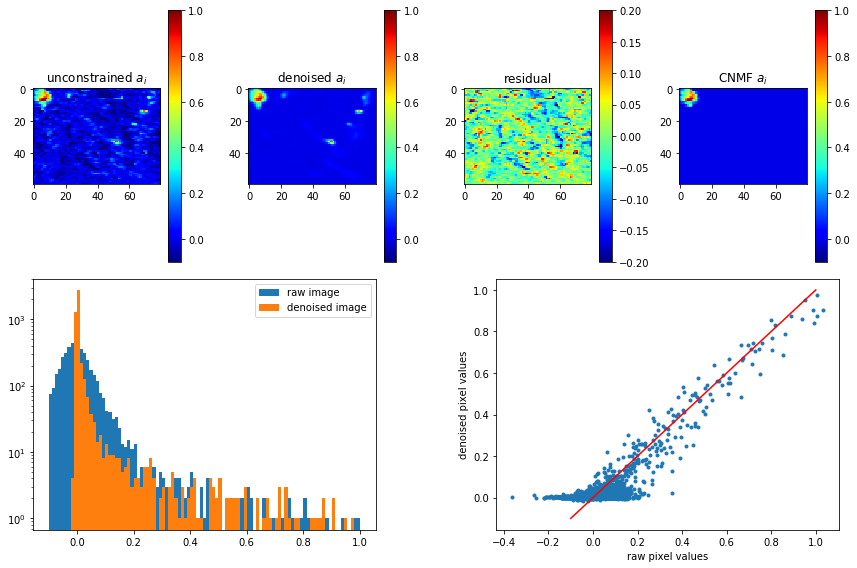

In [80]:
img_raw, img_denoised = plot_results(21)

# test baylor data 

In [84]:
real_data = sio.loadmat(os.path.join(data_path, 'baylor_data.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_em = real_data['A_em']

In [96]:
def plot_results(neuron_id, plane_id, cmap='jet'): 
    img_raw = A_corr[:, :, plane_id, neuron_id].reshape(1,1, 58, 129)
    noise = img_raw[img_raw!=0].std()
    img_raw = img_raw / img_raw.max() 
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, plane_id, neuron_id].squeeze()
    img_pi = A_em[:,:,plane_id, neuron_id].squeeze()
    
    imgs = [img_pi/img_pi.max(), img_ai/img_ai.max(), img_raw.squeeze(), img_denoised.squeeze(), img_output.squeeze()]
    titles = ['EM footprint', '2P footprint', 'corr. image', 'denoised corr. image', 'residual']
    fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    for img, title, ax in zip(imgs, titles, axs): 
        im = ax.imshow(img, cmap=cmap, clim=[-0.1, 0.5])
        ax.set_ylabel(title)
    

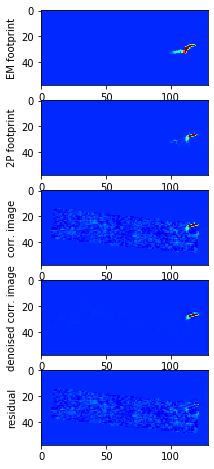

In [98]:
plot_results(20,2)